In [1]:
import os
import cv2
import pickle
import numpy as np
import pdb
import requests
from collections import defaultdict
import random 
import time

from sklearn import tree
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import *

import matplotlib.pyplot as plt
from functools import wraps
from time import time as _timenow 
from sys import stderr


## Load CIFAR-10 Data

In [2]:
def load_cifar():
    
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding ='latin1')
        return data
    
    for i in trange(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels


## Image preprocessing

In [3]:
def image_prep(train, test):
    ''' pre-processes the given image
        performs mean normalization and other such operations'''
    scaler = preprocessing.StandardScaler().fit(train)
    test_data = scaler.transform(test)
    train_data = scaler.transform(train)
    return train_data, test_data

## Dimensionality reduction using PCA

In [4]:
def reduce_dim(**kwargs):
    ''' performs dimensionality reduction'''
    if kwargs['method'] == 'pca':
        pca = PCA(n_components = kwargs['numbercomponents'])
        pca = pca.fit(kwargs['train'])
        train_new = pca.transform(kwargs['train'])
        test_new = pca.transform(kwargs['test'])
        return train_new, test_new
    elif kwargs['method'] == 'lda':
        c = LinearDiscriminantAnalysis(numbercomponents = 600)
        c = c.fit(kwargs['train'], kwargs['train_label'])
        train_new = c.transform(kwargs['train'])
        test_new = c.transform(kwargs['test'])
        return train_new, test_new
        

## Classification using kernel SVM

In [5]:
def classify(X, Y, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    if kwargs['method'] == 'CART':
        c = tree.DecisionTreeClassifier()
        c = c.fit(X, Y)
        return c

In [6]:
def classify_mlp(X, Y, hidden_layer1, hidden_layer2, hidden_layer3, **kwargs):
    ''' trains a classifier by taking input features
        and their respective targets and returns the trained model'''
    c = MLPClassifier(hidden_layer_sizes = (hidden_layer1, hidden_layer2, hidden_layer3), max_iter=200)
    c.fit(X, Y)
    return c
        


## Evaluation 

In [7]:
def evaluate(target, predicted):
    f1 = f1_score(target, predicted, average='micro')
    acc = accuracy_score(target, predicted)
    return f1, acc

In [8]:
def test(**kwargs):
    '''takes test data and trained classifier model,
    performs classification and prints accuracy and f1-score'''
    if kwargs['method'] == 'CART':
        output = kwargs['model'].predict(kwargs['test'])
    if kwargs['method'] == 'SVM':
        output = kwargs['model'].predict(kwargs['test'])
    return output

In [9]:
def find_pca_components():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels,test_size = 0.20) 
    acc = []
    xaxis = []
    i = 50
    while i <= 150:
        trn_data, tst_data = image_prep(X_train, X_test)
        trn_data, tst_data = reduce_dim(train = trn_data, test = tst_data, method ='pca', numbercomponents = i)
        model = classify(trn_data, Y_train, method ='CART')
        output = test(test = tst_data, model = model, method ='CART')
        f_score, accuracy = evaluate(Y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        xaxis.append(i)
        i += 10
        
    plt.plot(xaxis, acc)
    plt.xlabel('No. of components for PCA')
    plt.ylabel('Accuracy')
    plt.show()
    return acc, xaxis
    
    ''' perform dimesioality reduction/feature extraction and classify the features into one of 10 classses
        print accuracy and f1-score.
        '''


In [10]:
def find_min_samples_split():
    i=2
    acc=[]
    x_axis=[]
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels, test_size = 0.20) 
    while i <= 10:
        trn_data, tst_data = image_prep(X_train, X_test)
        trn_data, tst_data = reduce_dim(train = trn_data, test = tst_data, train_label = Y_train,method ='pca', numbercomponents = 100)
        model = classify(trn_data, Y_train, num_trees = 400, min_samples_split = i, method ='CART')
        output = test(test = tst_data, model = model, method ='CART')
        f_score, accuracy = evaluate(Y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        x_axis.append(i)
        i += 1
        
    plt.plot(x_axis, acc)
    plt.xlabel('No. of nodes in the decision tree')
    plt.ylabel('Accuracy')
    plt.show()
    return acc, x_axis

In [11]:
def find_n_estimators(): 
    number_of_trees = []
    acc = []
    i = 50
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels,test_size = 0.20) 
    while(i <= 400):
        trn_data, tst_data = image_prep(X_train, X_test)
        model = classify(trn_data, Y_train, num_trees = i, min_samples_split = 8, method = 'CART')
        output = test(test = tst_data, model= model, method = 'CART')
        f_score, accuracy = evaluate(Y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        number_of_trees.append(i)
        i += 50
        
    plt.plot(number_of_trees, acc)
    plt.xlabel('No. of trees')
    plt.ylabel('Accuracy')
    plt.show()
    return acc, number_of_trees

In [12]:
# PCA reduction
def final_pca():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)
    trn_data, tst_data = image_prep(X_train, tst_data)
    trn_data, tst_data = reduce_dim(train = trn_data, test = tst_data, train_label = Y_train, method = 'pca', numbercomponents = 100)
    model = classify(trn_data, Y_train, num_trees = 400, min_samples_split = 8,method = 'CART')
    output = test(test = tst_data, model = model, method = 'CART')
    f_score, accuracy = evaluate(tst_labels, output)
    print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
    

In [13]:
def find_lda_components():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels,test_size = 0.20) 
    acc = []
    xaxis = []
    i = 50
    while i <= 150:
        trn_data, tst_data = image_prep(X_train, X_test)
        trn_data, tst_data = reduce_dim(train = trn_data, test = tst_data, method ='lda', numbercomponents = i)
        model = classify(trn_data, Y_train, method ='CART')
        output = test(test = tst_data, model = model, method ='CART')
        f_score, accuracy = evaluate(Y_test, output)
        print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))
        acc.append(accuracy)
        xaxis.append(i)
        i += 10
        
    plt.plot(xaxis, acc)
    plt.xlabel('No. of components for PCA')
    plt.ylabel('Accuracy')
    plt.show()
    return acc, xaxis
    
    ''' perform dimesioality reduction/feature extraction and classify the features into one of 10 classses
        print accuracy and f1-score.
        '''


In [14]:
#  data reduction with LDA
def final_lda():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)
    trn_data, tst_data = image_prep(X_train, tst_data)
    trn_data, tst_data = reduce_dim(train = trn_data, test = tst_data, train_label = Y_train, method = 'lda', numbercomponents = 700)
    model = classify(trn_data, Y_train, num_trees = 300, min_samples_split = 5, method ='CART')
    output = test(test = tst_data, model = model, method = 'CART')
    f_score, accuracy = evaluate(tst_labels, output)
    print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))


In [15]:
def raw():
    trn_data, trn_labels, tst_data, tst_labels = load_cifar()
    X_train, X_test, Y_train, Y_test = train_test_split(trn_data, trn_labels, test_size = 0.20)
    trn_data, tst_data = image_prep(X_train, tst_data)
    model = classify(trn_data, Y_train, num_trees=300, min_samples_split=5, method='CART')
    output = test(test = tst_data, model= model, method='CART')
    f_score, accuracy = evaluate(tst_labels, output)
    print('Val - F1 score: {}\n Accuracy: {}'.format(f_score, accuracy))

100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Val - F1 score: 0.2415
 Accuracy: 0.2415
Val - F1 score: 0.232
 Accuracy: 0.232
Val - F1 score: 0.216
 Accuracy: 0.216
Val - F1 score: 0.239
 Accuracy: 0.239
Val - F1 score: 0.2245
 Accuracy: 0.2245
Val - F1 score: 0.2405
 Accuracy: 0.2405
Val - F1 score: 0.2315
 Accuracy: 0.2315
Val - F1 score: 0.2265
 Accuracy: 0.2265
Val - F1 score: 0.2145
 Accuracy: 0.2145
Val - F1 score: 0.2225
 Accuracy: 0.2225
Val - F1 score: 0.22400000000000003
 Accuracy: 0.224


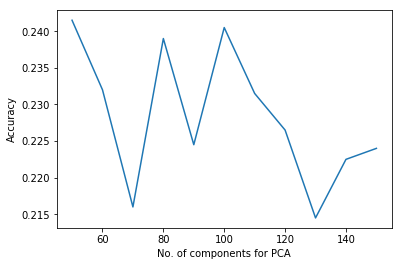

100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


Val - F1 score: 0.236
 Accuracy: 0.236
Val - F1 score: 0.226
 Accuracy: 0.226
Val - F1 score: 0.24
 Accuracy: 0.24
Val - F1 score: 0.2365
 Accuracy: 0.2365
Val - F1 score: 0.2245
 Accuracy: 0.2245
Val - F1 score: 0.233
 Accuracy: 0.233
Val - F1 score: 0.247
 Accuracy: 0.247
Val - F1 score: 0.2355
 Accuracy: 0.2355
Val - F1 score: 0.2315
 Accuracy: 0.2315


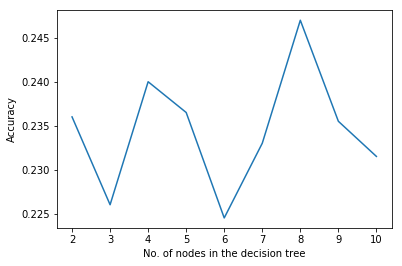

100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


Val - F1 score: 0.227
 Accuracy: 0.227
Val - F1 score: 0.2215
 Accuracy: 0.2215
Val - F1 score: 0.2175
 Accuracy: 0.2175
Val - F1 score: 0.22400000000000003
 Accuracy: 0.224
Val - F1 score: 0.2225
 Accuracy: 0.2225
Val - F1 score: 0.2285
 Accuracy: 0.2285
Val - F1 score: 0.2325
 Accuracy: 0.2325
Val - F1 score: 0.229
 Accuracy: 0.229


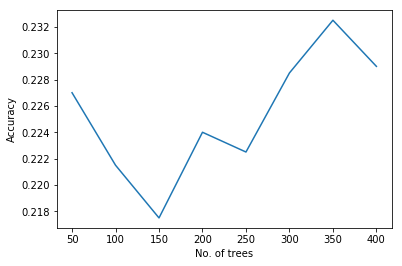

100%|██████████| 1/1 [00:00<00:00, 14.08it/s]

Val - F1 score: 0.2268
 Accuracy: 0.2268


NameError: name 'LinearDiscriminantAnalysis' is not defined

In [16]:
if __name__ == '__main__':
    
    find_pca_components()
    find_min_samples_split()
    find_n_estimators()
    final_pca()
    final_lda()
    